In [1]:
import pyspark
import warnings
warnings.filterwarnings("ignore")
import os 
dir_path = os.path.dirname(os.path.realpath('__file__'))
data_path=dir_path+"/bank/bank-full.csv"

sc = spark.sparkContext

# Load csv file 
Bank dataset is from UCI (http://archive.ics.uci.edu/ml/index.php)

In [29]:
df = sc.textFile(data_path)
header = df.first()
df =df.filter(lambda line: line != header)
df_var = df.map(lambda k: k.split(";"))
colname=header.split(";")
colname = [w.replace('"', '') for w in colname]
print colname
df=df_var.toDF(colname)
df.take(2)

[u'age', u'job', u'marital', u'education', u'default', u'balance', u'housing', u'loan', u'contact', u'day', u'month', u'duration', u'campaign', u'pdays', u'previous', u'poutcome', u'y']


[Row(age=u'58', job=u'"management"', marital=u'"married"', education=u'"tertiary"', default=u'"no"', balance=u'2143', housing=u'"yes"', loan=u'"no"', contact=u'"unknown"', day=u'5', month=u'"may"', duration=u'261', campaign=u'1', pdays=u'-1', previous=u'0', poutcome=u'"unknown"', y=u'"no"'),
 Row(age=u'44', job=u'"technician"', marital=u'"single"', education=u'"secondary"', default=u'"no"', balance=u'29', housing=u'"yes"', loan=u'"no"', contact=u'"unknown"', day=u'5', month=u'"may"', duration=u'151', campaign=u'1', pdays=u'-1', previous=u'0', poutcome=u'"unknown"', y=u'"no"')]

# Data cleaning. 
There is no missing data. 

In [3]:
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()


+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



# EDA by pandas

Now we check the y target distribution from the histogram. It indicated the inbalance data. 
We need to use f1 score to evalute the model performance. 

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pdf=df.toPandas()
pdf['y'].groupby(pdf['y']).count().plot(kind='bar');


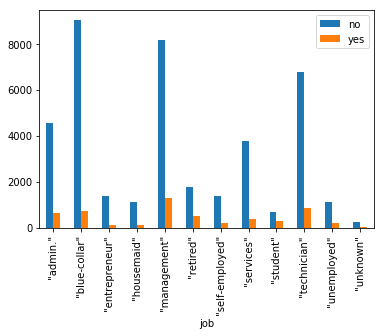

In [127]:
var=pdf.y.unique()
no=pdf[pdf.y==var[0]]['job'].groupby(pdf['job']).count()
yes=pdf[pdf.y==var[1]]['job'].groupby(pdf['job']).count()
pd.concat([no, yes], axis=1,keys=['no','yes']).plot(kind='bar');

# Feature transformation


In [30]:
from pyspark.sql.types import IntegerType

intcol=['age','balance','day','duration','campaign','pdays','previous']
for col in intcol:
    df = df.withColumn(col, df[col].cast(IntegerType()))

df.printSchema()
 

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



Next we convert catergorical variable to int by using StringIndexer. 


In [31]:
from pyspark.ml.feature import StringIndexer
catacol=['job','marital','education','default','housing','loan','contact','month','poutcome','y']
for col in catacol:
    indexer = StringIndexer(inputCol=col, outputCol=col+'index')
    df = indexer.fit(df).transform(df)
    df=df.drop(col)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- jobindex: double (nullable = true)
 |-- maritalindex: double (nullable = true)
 |-- educationindex: double (nullable = true)
 |-- defaultindex: double (nullable = true)
 |-- housingindex: double (nullable = true)
 |-- loanindex: double (nullable = true)
 |-- contactindex: double (nullable = true)
 |-- monthindex: double (nullable = true)
 |-- poutcomeindex: double (nullable = true)
 |-- yindex: double (nullable = true)



Check correlation between target

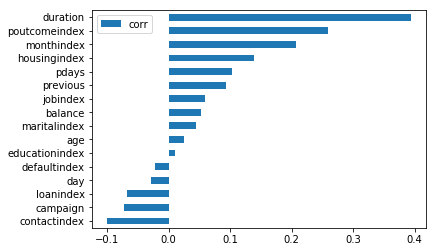

In [7]:
from pyspark.mllib.stat import Statistics
import numpy as np
#corr_mat=Statistics.corr(features, method="pearson")

colname=list(df.columns)
colname.pop()# remove 'yindex'
corr=[]
for col in colname:
    corr.append([col,df.stat.corr(col, "yindex")])
df_corr = sc.parallelize(corr).toDF(['name','corr'])
df_corr=df_corr.sort('corr')
pdf_corr=df_corr.toPandas()
ax=pdf_corr.plot.barh()
ax.set_yticklabels(pdf_corr['name'], rotation=0);# ; can hide the <matplotlib.text.Text at 0x11453a310> massage

In [23]:
badcol=['loanindex','campaign','contactindex']
for col in badcol:
    df=df.drop(col)
df.printSchema()

loanindex
campaign
contactindex
root
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- jobindex: double (nullable = true)
 |-- maritalindex: double (nullable = true)
 |-- educationindex: double (nullable = true)
 |-- defaultindex: double (nullable = true)
 |-- housingindex: double (nullable = true)
 |-- monthindex: double (nullable = true)
 |-- poutcomeindex: double (nullable = true)
 |-- yindex: double (nullable = true)



# Prepare training data

In [32]:
from pyspark.ml.linalg import DenseVector
input_data=df.rdd.map(lambda x:(x[-1],DenseVector(x[:-2])))
df_d=spark.createDataFrame(input_data,["label","features"])
df_d.take(2)

[Row(label=0.0, features=DenseVector([58.0, 2143.0, 5.0, 261.0, 1.0, -1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0])),
 Row(label=0.0, features=DenseVector([44.0, 29.0, 5.0, 151.0, 1.0, -1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]))]

In [33]:

from pyspark.ml.feature import StandardScaler
sclr=StandardScaler(inputCol='features',outputCol='features_scaled')
scaler=sclr.fit(df_d)
scaled_df=scaler.transform(df_d)
scaled_df.take(2)


[Row(label=0.0, features=DenseVector([58.0, 2143.0, 5.0, 261.0, 1.0, -1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), features_scaled=DenseVector([5.462, 0.7038, 0.6008, 1.0135, 0.3228, -0.01, 0.0, 0.3748, 0.0, 1.154, 0.0, 0.0, 0.0, 1.6405, 0.0])),
 Row(label=0.0, features=DenseVector([44.0, 29.0, 5.0, 151.0, 1.0, -1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]), features_scaled=DenseVector([4.1436, 0.0095, 0.6008, 0.5863, 0.3228, -0.01, 0.0, 0.7496, 1.4431, 0.0, 0.0, 0.0, 0.0, 1.6405, 0.0]))]

In [34]:
train_df,test_df=df_d.randomSplit([0.8,0.2],seed=42)
test_df.take(2)

[Row(label=0.0, features=DenseVector([20.0, -172.0, 19.0, 238.0, 3.0, -1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0])),
 Row(label=0.0, features=DenseVector([20.0, -103.0, 13.0, 180.0, 1.0, -1.0, 0.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]))]

# Train Model

In [134]:
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train_df)

# Compute raw scores on the test set
y_p=lrModel.transform(test_df)
y_pred=y_p.select('prediction').rdd.map(lambda x:x[0])#predicted
y_t=y_p.select('label').rdd.map(lambda x:x[0])#target
predictionAndLabels=y_pred.zip(y_t)
predictionAndLabels.collect()
print 'training done'    

training done


In [35]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# Train model.  This also runs the indexers.
rfmodel = rf.fit(train_df)

# Make predictions.
y_p = rfmodel.transform(test_df)
y_pred=y_p.select('prediction').rdd.map(lambda x:x[0])#predicted
y_t=y_p.select('label').rdd.map(lambda x:x[0])#target
predictionAndLabels=y_pred.zip(y_t)
print 'training done'  

training done


# Model evaluation 
The test f1 score is 89%. 

In [36]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics=MulticlassMetrics(predictionAndLabels)
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()

print('f1score %s'%f1Score)


f1score 0.890215329689


In [ ]:
sc.stop()

# Future work 
1. Feature engineering: one to hot encode catagorical variable, more EDA.
2. n-way interaction 
3. Try xgboost and other ensemble model
4. Stacking ensemble. 
5. Learning curve. 
